The World Cup Problem: Germany v. Argentina
-------------------------------------------

Allen Downey

This notebook contains a solution to a problem I posed in my Bayesian statistics class:

> In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0.  How much evidence 
> does this victory provide that Germany had the better team?  What is the probability that Germany
> would win a rematch?

Scoring in games like soccer and hockey can be (reasonably) well modeled by a Poisson process, which assumes that each team, against a given opponent, will score goals at some goal-scoring rate, $\lambda$, and that this rate is stationary; in other words, the probability of scoring a goal is about the same at any point during the game.

Based on this modeling decision, we can answer the questions by

1. Defining a prior distribution for each team's goal-scoring rate against the other,
2. Updating the prior based on the outcome of the game,
3. Using the posterior distributions to compute the probability that Germany's goal-scoring rate is higher.
4. Generating a predictive distribution for the number of goals each team would score in a rematch.

My solution uses the ThinkBayes2 framework, which is described in [Think Bayes](http://thinkbayes.com), and summarized in [this notebook](http://nbviewer.ipython.org/github/AllenDowney/ThinkBayes2/blob/master/code/framework.ipynb).

I'll start with Step 2.

### Step 2: Updating

If goal-scoring is a Poisson process, the distribution of goals per game is Poisson with parameter $\lambda$.  To compute the distribution of $\lambda$ we can define a new class that inherits from `thinkbayes2.Suite` and provides an appropriate `Likelihood` function:

In [10]:
import thinkbayes

class Soccer(thinkbayes.Suite):
    """Represents hypotheses about goal-scoring rates."""

    def likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: goal rate in goals per game
        data: interarrival time in minutes
        """
        goals = data
        lam = hypo
        like = thinkbayes.eval_poisson_pmf(goals, lam)
        return like

`Likelihood` computes the likelihood of `data` given `hypo`, where `data` is an observed number of goals, and `hypo` is a hypothetical goal-scoring rate in goals per game.  We can compute the likelihood of the data by evaluating the Poisson probability mass function (PMF).

Now we can get back to Step 1.

### Step 1: Constructing the prior

Before the game starts, what should we believe about each team's goal scoring rate against each other?  We could use previous tournament results to construct the priors, but to keep things simple, I'll just use the average goal-scoring rate from all matches in the tournament, which was 2.67 goals per game (total for both teams).

To construct the prior, I'll start with an unrealistic uniform distribution and update it with fake data until the mean matches the observed rate for a single team, 1.34 goals per game.

In [11]:
import numpy
from thinkbayes import thinkplot

hypos = numpy.linspace(0, 12, 201)
suite = Soccer(hypos)
suite.update(0.33)                # fake data chosen by trial and error to yield the observed prior mean

thinkplot.plot_pdf_line(suite)
suite.mean()

ValueError: Normalize: total probability is zero.

According to this prior, the goal-scoring rates are always greater than zero, with the most likely value (a priori) near 0.5.  Goal scoring rates greater than 5 are considered unlikely.

### Step 2: Comparing posteriors

The next step is to compute the posteriors for the two teams:

In [4]:
germany = suite.Copy(label='Germany')
argentina = suite.Copy(label='Argentina')
germany.Update(1)
argentina.Update(0)

print('posterior mean Germany', germany.Mean())
print('posterior mean Argentina', argentina.Mean())

posterior mean Germany 1.16529110336
posterior mean Argentina 0.677218426967


`Update` invokes the likelihood function for each hypothetical value of $\lambda$ and updates the distribution accordingly.

Since both teams scored fewer goals than the prior mean (1.4), we expect both posterior means to be lower.  Germany's posterior mean is 1.2; Argentina's is 0.7.  We can plot the posteriors:

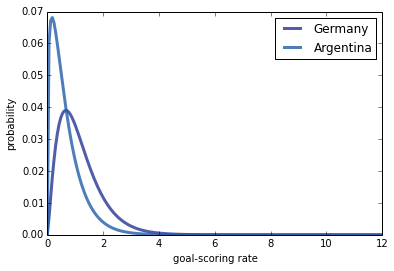

In [5]:
thinkplot.Pdf(germany)
thinkplot.Pdf(argentina)
thinkplot.Config(xlabel='goal-scoring rate', ylabel='probability')

To answer the first question, "How much evidence does this victory provide that Germany had the better team?", we can compute the posterior probability that Germany had a higher goal-scoring rate:

In [6]:
post_prob = germany > argentina
print('posterior prob Germany > Argentina', post_prob)

posterior prob Germany > Argentina 0.704322830196


Based on the prior distributions, we would have said that Germany had a 50% chance of having the better team, or 1:1 odds.  Based on the posteriors, we would say that Germany has a 70% chance.  We can use the ratio of the prior and posterior odds to compute the Bayes factor, which measures the strength of the evidence.

In [7]:
prior_odds = 1
post_odds = post_prob / (1 - post_prob)
print('posterior odds Germany > Argentina', post_odds)   
k = post_odds / prior_odds
print('Bayes factor', k)   

posterior odds Germany > Argentina 2.38206700457
Bayes factor 2.38206700457


The Bayes factor is 2.4, which is generally considered weak evidence.

Now on to Step 4.

### Step 4: The predictive distributions

If we knew the actual goal scoring rate, $\lambda$, we could predict how many goals each team work score in a rematch.  The distribution of goals would be Poisson with parameter $\lambda t$.

We don't actually know $\lambda$, but we can use the posterior distribution of $\lambda$ to generate a predictive distribution for the number of additional goals.

In [8]:
def PredictiveDist(suite, duration=1, label='pred'):
    """Computes the distribution of goals scored in a game.

    returns: new Pmf (mixture of Poissons)
    """
    metapmf = thinkbayes2.Pmf()
    for lam, prob in suite.Items():
        pred = thinkbayes2.MakePoissonPmf(lam * duration, 15)
        metapmf[pred] = prob

    mix = thinkbayes2.MakeMixture(metapmf, label=label)
    return mix

germany_pred = PredictiveDist(germany, label='germany')
argentina_pred = PredictiveDist(argentina, label='argentina')


`PredictiveDist` takes the posterior distribution of $\lambda$ and a duration (in units of games).

It loops through the hypotheses in `suite`, computes the predictive distribution of goals for each hypothesis, and assembles a "meta-Pmf" which is a Pmf that maps from each predictive distribution to its probability.

Finally, it uses `MakeMixture` to compute the mixture of the distributions.  Here's what the predictive distributions look like.

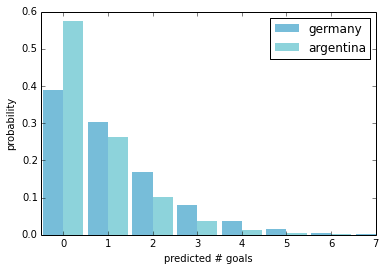

In [9]:
thinkplot.Hist(germany_pred, width=0.45, align='right')
thinkplot.Hist(argentina_pred, width=0.45, align='left')
thinkplot.Config(xlabel='predicted # goals', ylabel='probability', xlim=[-0.5, 7])

Using the predictive distributions, we can compute probabilities for the outcomes of a rematch.

In [10]:
win = germany_pred > argentina_pred
lose = germany_pred < argentina_pred
tie = 1 - (win + lose)

print('posterior prob Germany wins rematch', win)
print('posterior prob Argentina wins rematch', lose)
print('posterior prob tie', tie)

posterior prob Germany wins rematch 0.450511695667
posterior prob Argentina wins rematch 0.225540779355
posterior prob tie 0.323947524978


If the score is tied after 90 minutes the teams play an additional 30 minute period.  We can use `PredictiveDist` again to compute the distribution of scores after 1/3 of a game:

In [11]:
germany_pred_overtime = PredictiveDist(germany, 1/3, label='germany')
argentina_pred_overtime = PredictiveDist(argentina, 1/3, label='argentina')

In [12]:
win = germany_pred_overtime > argentina_pred_overtime
lose = germany_pred_overtime < argentina_pred_overtime
tie = 1 - (win + lose)

print('posterior prob Germany wins rematch', win)
print('posterior prob Argentina wins rematch', lose)
print('posterior prob tie', tie)

posterior prob Germany wins rematch 0.256156067229
posterior prob Argentina wins rematch 0.13931727161
posterior prob tie 0.604526661162


In [13]:
print('Total prob Germany wins a rematch', 0.45 + 0.32 * 0.26)

Total prob Germany wins a rematch 0.5332


In [14]:
print('Total prob Argentina wins', 0.23 + 0.32 * 0.14)

Total prob Argentina wins 0.2748


In [15]:
print('Prob of draw after overtime', 0.32 * 0.60)

Prob of draw after overtime 0.192
